# ResNet Ablation Study

resnet을 이용해서 residual connection의 효과를 ablation study해보자.

## 0. 모듈 import

In [1]:
# TensorFlow and tf.keras
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Add, ReLU

# Helper libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 1) ResNet 기본 블록 구성하기

resnet34와 50의 반복되는 block을 함수로 만들어보자.  
resnet50부터는 bottleneck block으로 3개의 conv 레이어로 채널의 크기를 줄이고 다시 늘린다.  
34까지의 기본이 되는 블록과 50에 해당하는 bottleneck 블록을 따로 구현해보자

논문에서는 같은 채널을 가지는 블록들의 이름을 conv2_x ~ conv5_x로 4단계로 나누는데,  
블록에 있는 BN layer와 ReLU, Add 레이어들에도 같은 이름을 붙이기에는 이름이 애매하므로,  
같은 채널을 공유하는 2~5단계의 stage와 같은 스테이지에서 반복되는 블록번호_레이어로 이름을 정하였다.

### Residual Bolck

기본 블록은 레이어들의 출력으로 같은 채널을 가지므로 하나의 채널을 입력받게 만들었다. 

논문에 나와있는 Figure 3을 참고해서 downsampling 할 경우 첫번째 conv에 strides=2를 준다.  
그리고 논문에 나와있는 
> The projection shortcut in Eqn.(2) is used to match dimensions (done by 1×1 convolutions). For both options, when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2.

내용에 따라 출력의 채널이 변하는 경우 shortcut을 1x1 conv에 strides=2 과정을 추가한다.

In [2]:
def residual_bolck(input_layer, channel, block_num=0, stage_num=0):
    strides = 2 if input_layer.shape[-1]*2 == channel else 1

    # conv2D
    name = f'stage{stage_num}_block{block_num}'
    x = Conv2D(channel, 3, strides=strides, padding='same',
               name=f'{name}_conv1')(input_layer)
    x = BatchNormalization(name=f'{name}_BN1')(x)
    x = ReLU(name=f'{name}_ReLU1')(x)
    x = Conv2D(channel, 3, padding='same', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_BN2')(x)

    # shortcut 계산
    shortcut = input_layer
    if input_layer.shape[-1] != channel:
        shortcut = Conv2D(channel, 1, strides=strides,
                          padding='same', name=f'{name}_shortcut_conv')(shortcut)
        shortcut = BatchNormalization(name=f'{name}_shortcut_BN')(shortcut)

    # shortcut을 더해주고 relu
    x = Add(name=f'{name}_Add')([x, shortcut])
    output = ReLU(name=f'{name}_ReLU2')(x)

    return output

### Bottleneck Bolck

기본블록과 구조는 같지만 파라미터로 받은 채널로 두번의 conv후에 4배 크기의 conv를 한번더 통과한다.  

스테이지가 바뀌면서 다운샘플링될 때는 기본 블록과 마찬가지로 shortcut을 계산한다.  
그리고 논문 Table1의 표 밑에 나와있는
> Table 1. Architectures for ImageNet. Building blocks are shown in brackets (see also Fig. 5), with the numbers of blocks stacked. Downsampling is performed by conv3 1, conv4 1, and conv5 1 with a stride of 2.

내용에 따라 1x1, 3x3, 1x1의 conv중 첫번째 1x1 conv에 strides=2로 다운샘플링한다.

In [3]:
def bottleneck_bolck(input_layer, channel, block_num=0, stage_num=0):
    strides = 2 if input_layer.shape[-1] == channel*2 else 1
    
    # conv2D
    name = f'stage{stage_num}_block{block_num}'
    x = Conv2D(channel, 1, strides=strides, padding='same', name=f'{name}_conv1')(input_layer)
    x = BatchNormalization(name=f'{name}_BN1')(x)
    x = ReLU(name=f'{name}_ReLU1')(x)
    x = Conv2D(channel, 3, padding='same', name=f'{name}_conv2')(x)
    x = BatchNormalization(name=f'{name}_BN2')(x)
    x = ReLU(name=f'{name}_ReLU2')(x)
    x = Conv2D(channel*4, 1, padding='same', name=f'{name}_conv3')(x)
    x = BatchNormalization(name=f'{name}_BN3')(x)
    
    # shortcut 계산
    shortcut = input_layer
    if input_layer.shape[-1] != channel*4:
        shortcut = Conv2D(channel*4, 1, strides=strides, 
                          padding='same', name=f'{name}_shortcut_conv')(shortcut)
        shortcut = BatchNormalization(name=f'{name}_shortcut_BN')(shortcut)

    # shortcut을 더해주고 relu
    x = Add(name=f'{name}_Add')([x, shortcut])
    output = ReLU(name=f'{name}_ReLU3')(x)

    return output

## 3) ResNet-34, ResNet-50 Complete Model

resnet 34와 50 모델을 만드는 함수이다.

두 모델 모두 block의 구성만 제외하면 같은 구성이다.  
처음 64채널로 출력하는 7x7 strides=2 conv, BN, ReLU까지가 stage1이고,  
3x3 strides=2 max pool레이어부터는 stage2이다.  

인자로 받은 is_50여부에 따라 base residual 블록이나 bottleneck block 블록을 만든다.  
논문의 마지막에 average pool후에 1000d softmax부분은  
global averagepooling과 라벨클래스와 같은 출력의 dense로 구현하였다.

In [4]:
def build_resnet(input_shape=(32, 32, 3), is_50=False, num_classes=10):
    channel_list = [64, 128, 256, 512]
    block_num_list = [3, 4, 6, 3]
    
    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer
    
    x = Conv2D(64, 7, strides=2, padding='same', name = f'stage1_conv')(input_layer)
    x = BatchNormalization(name = f'stage1_BN')(x)
    x = ReLU(name = f'stage1_ReLU')(x)
    
    # resnet stage 2~5
    x = MaxPool2D(3, strides=2, padding='same', name = f'stage2_MaxPool')(x)
    block = bottleneck_bolck if is_50 else residual_bolck
    for i, channel in enumerate(channel_list):
        for block_num in range(1, block_num_list[i]+1):
            x = block(x, channel, block_num=block_num, stage_num=i+2)
    
    # classifer
    x = keras.layers.GlobalAveragePooling2D()(x)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    return model

이제 만들어둔 함수로 resnet 34와 50 모델을 만들어서 (32, 32, 3)입력시의 summary를 확인해보자.

### ResNet-34

In [5]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_ReLU (ReLU)              (None, 16, 16, 64)   0           stage1_BN[0][0]                  
______________________________________________________________________________________________

### ResNet-50

In [6]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 16, 16, 64)   256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_ReLU (ReLU)              (None, 16, 16, 64)   0           stage1_BN[0][0]                  
____________________________________________________________________________________________

## 3) 일반 네트워크(plain network) 만들기

위에서 만든 함수들을 수정해서 같은 구조에서 residual connection만 없는  
plain network를 만들어보자.


그냥 기존의 base residual block과 bottleneck block을 하나로 합치고  
여기에 is_plain 인자로 resnet과 일반네트워크를 모두 만드는 함수로 통합하였다.

### 블록 코드 수정하기
기본 블록과 bottleneck 블록을 통합하였고,  
인자로 출력할 conv 채널리스트와 커널리스트를 받는다.

마찬가지로 인자로 받은 is_plain여부에 따라 shorcut계산과 add를 통한  
residual자체를 뺄수도 있게 만들었다.  
resnet의 경우 다운샘플링시에 모두 첫번째 conv에서 strides=2를 주었다.

In [7]:
def residual_bolck(input_layer, channels, kernels, block_num=0, stage_num=0, is_downsample=False, is_plain=False):
    strides = (2, 2) if is_downsample else (1, 1)
    basename = f'stage{stage_num}_block{block_num}'

    # conv2d
    x = input_layer
    for cnn_num, (channel, kernel) in enumerate(zip(channels, kernels), start=1):
        x = Conv2D(channel,
                   kernel_size=kernel,
                   strides=strides if cnn_num == 1 else (1, 1),
                   padding='same',
                   name=f'{basename}_conv{cnn_num}')(x)
        x = BatchNormalization(name=f'{basename}_BN{cnn_num}')(x)
        if cnn_num < len(channels):
            x = ReLU(name=f'{basename}_ReLU{cnn_num}')(x)
            
    if not is_plain:
        # shortcut 계산
        shortcut = input_layer
        if input_layer.shape[-1] != x.shape[-1]:
            shortcut = Conv2D(channel,
                              kernel_size=(1, 1),
                              strides=strides,
                              padding='same',
                              name=f'{basename}_shortcut_conv')(shortcut)
            shortcut = BatchNormalization(name=f'{basename}_shortcut_BN')(shortcut)

        # shortcut을 더해주고 relu
        x = Add(name=f'{basename}_Add')([x, shortcut])

    output = ReLU(name=f'{basename}_ReLU{cnn_num}')(x)

    return output


### 전체 함수 코드 수정하기

모델 build함수도 일반 네트워크와 resnet을 모두 만들 수 있게 변경하였다.  
레이어의 구조는 변하지 않았다.

In [8]:
def build_resnet(num_classes, input_shape=(224, 224, 3), is_50=False, is_plain=False):
    channel_list = [64, 128, 256, 512]
    block_num_list = [3, 4, 6, 3]

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    x = Conv2D(64, 7, strides=2, padding='same', name = f'stage1_conv')(input_layer)
    x = BatchNormalization(name = f'stage1_BN')(x)
    x = ReLU(name = f'stage1_ReLU')(x)
    
    # resnet stage 2~5
    x = MaxPool2D(3, strides=2, padding='same', name = f'stage2_MaxPool')(x)
    for i, channel in enumerate(channel_list):
        if is_50:
            channels = [channel, channel, channel*4]
            kernels = [1, 3, 1]
        else:
            channels = [channel, channel]
            kernels = [3, 3]
        for block_num in range(1, block_num_list[i]+1):
            is_downsample = False if block_num != 1 or i == 0 else True
            x = residual_bolck(x, channels, kernels, block_num=block_num, stage_num=i+2,
                               is_downsample=is_downsample, is_plain=is_plain)

    # classifer
    x = keras.layers.GlobalAveragePooling2D()(x)
    output = keras.layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=output)
    return model

새롭게 만든 함수로 34 or 50 / resnet or plain의 조합으로 4가지 모델을 생성하자.

### Plain-34

In [9]:
plain_34 = build_resnet(2, is_plain=True)
plain_34.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
stage1_ReLU (ReLU)           (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_MaxPool (MaxPooling2D (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_block1_conv1 (Conv2D) (None, 56, 56, 64)        36928     
_________________________________________________________________
stage2_block1_BN1 (BatchNorm (None, 56, 56, 64)        256 

### Plain-50

In [10]:
plain_50 = build_resnet(2, is_plain=True, is_50=True)
plain_50.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
stage1_conv (Conv2D)         (None, 112, 112, 64)      9472      
_________________________________________________________________
stage1_BN (BatchNormalizatio (None, 112, 112, 64)      256       
_________________________________________________________________
stage1_ReLU (ReLU)           (None, 112, 112, 64)      0         
_________________________________________________________________
stage2_MaxPool (MaxPooling2D (None, 56, 56, 64)        0         
_________________________________________________________________
stage2_block1_conv1 (Conv2D) (None, 56, 56, 64)        4160      
_________________________________________________________________
stage2_block1_BN1 (BatchNorm (None, 56, 56, 64)        256 

### ResNet-34

In [11]:
resnet_34 = build_resnet(2)
resnet_34.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_5[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_ReLU (ReLU)              (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

### ResNet-50

In [12]:
resnet_50 = build_resnet(2, is_50=True)
resnet_50.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stage1_conv (Conv2D)            (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
stage1_BN (BatchNormalization)  (None, 112, 112, 64) 256         stage1_conv[0][0]                
__________________________________________________________________________________________________
stage1_ReLU (ReLU)              (None, 112, 112, 64) 0           stage1_BN[0][0]                  
____________________________________________________________________________________________

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

위의 만든 모델들의 서머리를 보면 34와 50 모두 residual layer를 제외하면  
완전히 같은 구조인 것을 확인 할 수 있다.  

이제 같은 데이터셋으로 4가지 모델을 학습시켜서 같은 모델끼리의 학습결과를 비교해보자.

### Ablation Study

학습에 사용할 모델은 tensorflow dataset에서 제공하는 cats_vs_dogs이다.

출처 : https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

In [13]:
BATCH_SIZE = 32
EPOCH = 40

데이터셋 자체에 test데이터가 따로 없어서 train데이터를 나누어 test데이터를 만든다.  
train을 전체데이터에 80%로 나머지 20%를 test 데이터사용한다.

In [14]:
(ds_train, ds_test), ds_info = tfds.load('cats_vs_dogs', 
                                         split=['train[:80%]', 'train[80%:]'], 
                                         as_supervised=True, 
                                         shuffle_files=True, 
                                         with_info=True)

In [15]:
label_names = ds_info.features["label"].names
label_names

['cat', 'dog']

데이터는 image와 고양이=0, 개=1 의 라벨로 이루어져 있다.  
불러온 학습데이터와 테스트데이터의 개수를 확인해보자.

In [16]:
num_train, num_test = tf.data.experimental.cardinality(ds_train), tf.data.experimental.cardinality(ds_test)

print(f"학습 데이터 개수 : {num_train}")
print(f"테스트 데이터 개수 : {num_test}")

학습 데이터 개수 : 18610
테스트 데이터 개수 : 4652


전체 데이터의 일부분을 셔플해서 가져오면서 데이터의  
inbalance가 일어났는지 확인하기 위해 각 라벨의 개수를 구해보자.

In [17]:
cat_count = 0
for img, label in ds_train:
    if label == 1:
        cat_count += 1
        
print(f"고양이 라벨 개수 : {cat_count}")
print(f"고양이 라벨 개수 : {num_train - cat_count}")

고양이 라벨 개수 : 9232
고양이 라벨 개수 : 9378


라벨의 비율은 적당하다.  
각 이미지 몇개를 샘플해보자.

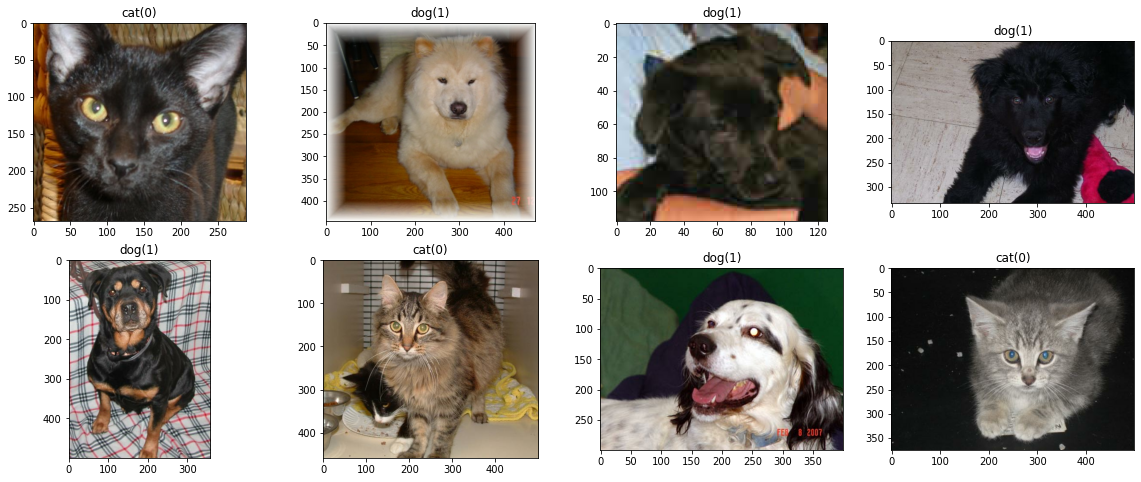

In [18]:
#fig = tfds.show_examples(ds_train, ds_info)

fig, _ = plt.subplots(2, 4, figsize=(20,8))
for ax, (img, label) in zip(fig.axes, ds_train):
    ax.imshow(img)
    ax.set_title(f'{label_names[label]}({label})')
plt.show()

각 이미지의 크기가 다르고, 범위도 0~255의 uint이다.  
이미지를 정규화시켜주고 사이즈도 224 * 244의 크기로 전처리해주자.

In [19]:
def preprocess(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.divide(img, 255)
    img = tf.image.resize(img, (224, 224))
    return img, label


ds_train = ds_train.map(preprocess)
ds_test = ds_test.map(preprocess)

전처리된 이미지를 다시 샘플링해보자.

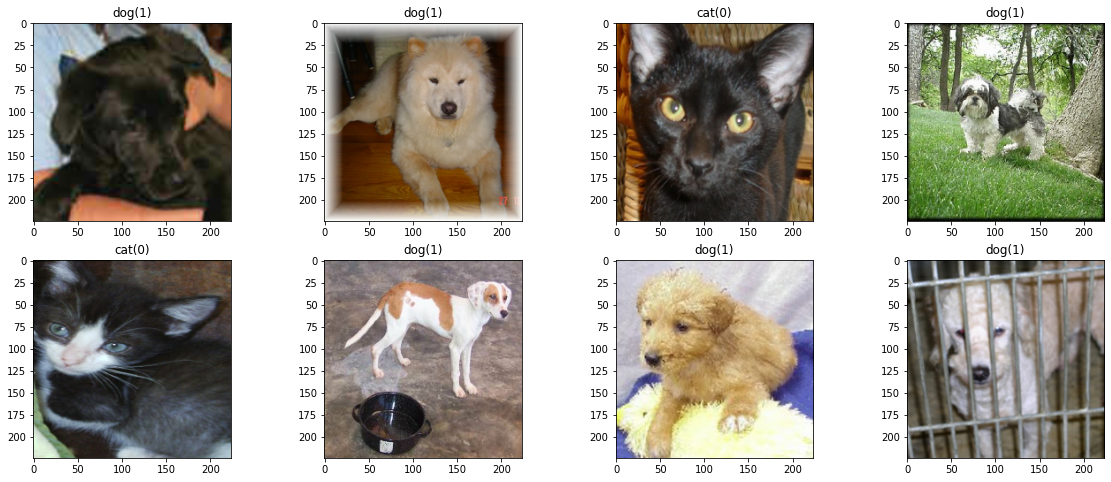

In [20]:
#fig = tfds.show_examples(ds_train, ds_info)

fig, _ = plt.subplots(2, 4, figsize=(20,8))
for ax, (img, label) in zip(fig.axes, ds_train):
    ax.imshow(img)
    ax.set_title(f'{label_names[label]}({label})')
plt.show()

전처리를 잘되었고 이제 배치사이즈에 맞게 다시 데이터셋을 구성하자.

In [21]:
ds_train = ds_train.batch(BATCH_SIZE).repeat().prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).repeat().prefetch(tf.data.experimental.AUTOTUNE)

논문에서는 optimizer 설정을 다음과 같이 한다.
> We use SGD with a mini-batch size of 256. The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 104 iterations. We use a weight decay of 0.0001 and a momentum of 0.9.

현재 환경에서는 gpu의 메모리 문제로 최대 배치인 64를 사용한다.  
여러가지로 실험해본 결과 plain-34 모델에서 0.1까지 학습이 잘되지만,  
plain-50 모델이 0.05까지도 학습이 잘되지 않아, 시작 learning rate를 0.01로 주었다.

논문에 나온것과 같이 decay와 momentum을 사용하였고, accuracy가 어느정도 수렴하면  
기존의 learning rate에 10을 나누어주는 방식을 사용한다.

이는 tensorflow의 매 상황마다의 callback함수를 이용해서 매 epoch의 끝에서 수렴하는지 확인하고 변경한다.

In [22]:
class ConvergenceWatcher(tf.keras.callbacks.Callback):
    use_change = False

    def __init__(self, min_count=4, alpha=0.99):
        super().__init__()
        self.before_error = 1
        self.continue_count = 0
        self.min_count = min_count
        self.alpha = alpha
        ConvergenceWatcher.use_change = False

    def on_epoch_end(self, epoch, logs):
        error = 1.0 - logs['accuracy']
        if error >= self.before_error*self.alpha:
            self.continue_count += 1
            if self.continue_count >= self.min_count:
                self.continue_count = 0
                ConvergenceWatcher.use_change = True
        else:
            self.continue_count = 0
            self.before_error = min(error, self.before_error)


def scheduler(epoch, lr):
    if ConvergenceWatcher.use_change:
        ConvergenceWatcher.use_change = False
        print(f"epoch : {epoch}, before lr : {lr} => after lr : {lr * 0.1}")
        return lr * 0.1
    return lr

In [23]:
def train(model, name, epoch=EPOCH, batch_size=BATCH_SIZE, lr=0.01):
    model.compile(optimizer=tf.keras.optimizers.SGD(lr=lr, momentum=0.9, decay=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    hist = model.fit(ds_train,
                     epochs=epoch,
                     steps_per_epoch=num_train/batch_size,
                     validation_steps=num_test/batch_size,
                     validation_data=ds_test,
                     verbose=1,
                     callbacks=[ConvergenceWatcher(),
                                tf.keras.callbacks.LearningRateScheduler(scheduler)],
                     use_multiprocessing=True)
    
    model.save(f'save/{name}_epoch_{epoch}_lr_{lr}.h5')
    np.save(f'save/hist_{name}_epoch_{epoch}_lr_{lr}.npy', hist.history)
    return hist

### Plain-34 학습

In [24]:
hist_plain_34 = train(plain_34, 'plain34')

Train for 581.9375 steps, validate for 145.0 steps
Epoch 1/40
582/581 [==============================] - 102s 175ms/step - loss: 0.7039 - accuracy: 0.5543 - val_loss: 0.6538 - val_accuracy: 0.6259
Epoch 2/40
582/581 [==============================] - 96s 164ms/step - loss: 0.6542 - accuracy: 0.6180 - val_loss: 0.6821 - val_accuracy: 0.5858
Epoch 3/40
582/581 [==============================] - 94s 162ms/step - loss: 0.6321 - accuracy: 0.6437 - val_loss: 0.6216 - val_accuracy: 0.6513
Epoch 4/40
582/581 [==============================] - 95s 162ms/step - loss: 0.6157 - accuracy: 0.6614 - val_loss: 0.5976 - val_accuracy: 0.6776
Epoch 5/40
582/581 [==============================] - 97s 167ms/step - loss: 0.5913 - accuracy: 0.6866 - val_loss: 0.6520 - val_accuracy: 0.6384
Epoch 6/40
582/581 [==============================] - 95s 163ms/step - loss: 0.5621 - accuracy: 0.7078 - val_loss: 0.8115 - val_accuracy: 0.5707
Epoch 7/40
582/581 [==============================] - 94s 162ms/step - loss: 0

각 모델의 학습과정 중에 loss와 accuracy를 그리는 함수이다.  
error는 1-accuracy를 나타낸다.

In [25]:
def draw_history(history, model_name):
    plt.figure(figsize=(24, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], 'r')
    plt.plot(history.history['val_loss'], 'b')
    plt.title(f'{model_name} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['loss', 'val_loss'], loc='upper left')

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], 'r')
    plt.plot(history.history['val_accuracy'], 'b')
    plt.title(f'{model_name} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')

    plt.subplot(1, 3, 3)
    plt.plot([1-x for x in history.history['accuracy']], 'r')
    plt.plot([1-x for x in history.history['val_accuracy']], 'b')
    plt.title('Model error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['error', 'val_error'], loc='upper right')

    plt.show()

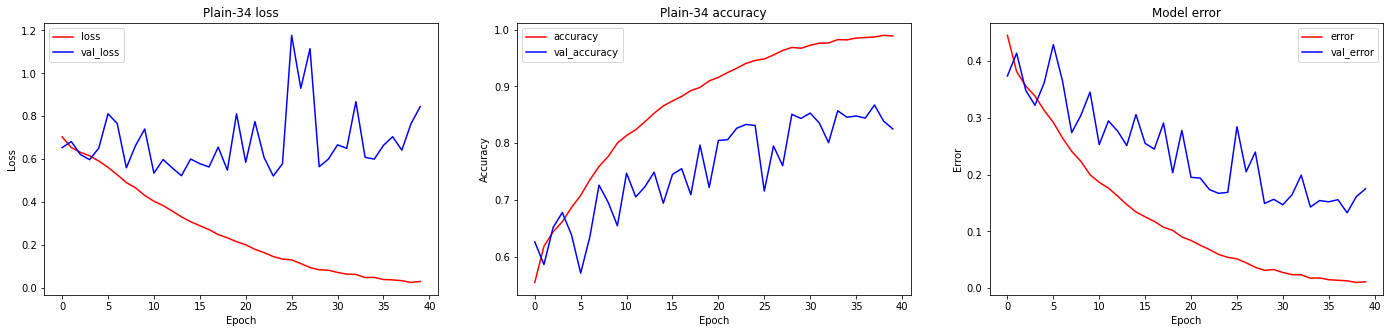

In [26]:
draw_history(hist_plain_34, 'Plain-34')

### Plain-50 학습

In [27]:
hist_plain_50 = train(plain_50, 'plain50')

Train for 581.9375 steps, validate for 145.0 steps
Epoch 1/40
582/581 [==============================] - 154s 265ms/step - loss: 0.7381 - accuracy: 0.5220 - val_loss: 0.6916 - val_accuracy: 0.5407
Epoch 2/40
582/581 [==============================] - 145s 249ms/step - loss: 0.7005 - accuracy: 0.5369 - val_loss: 0.6898 - val_accuracy: 0.5515
Epoch 3/40
582/581 [==============================] - 146s 252ms/step - loss: 0.6759 - accuracy: 0.5785 - val_loss: 0.6512 - val_accuracy: 0.6343
Epoch 4/40
582/581 [==============================] - 148s 255ms/step - loss: 0.6436 - accuracy: 0.6400 - val_loss: 0.6553 - val_accuracy: 0.6162
Epoch 5/40
582/581 [==============================] - 150s 257ms/step - loss: 0.6255 - accuracy: 0.6578 - val_loss: 0.6057 - val_accuracy: 0.6724
Epoch 6/40
582/581 [==============================] - 150s 258ms/step - loss: 0.6065 - accuracy: 0.6755 - val_loss: 0.6378 - val_accuracy: 0.6515
Epoch 7/40
582/581 [==============================] - 150s 257ms/step - l

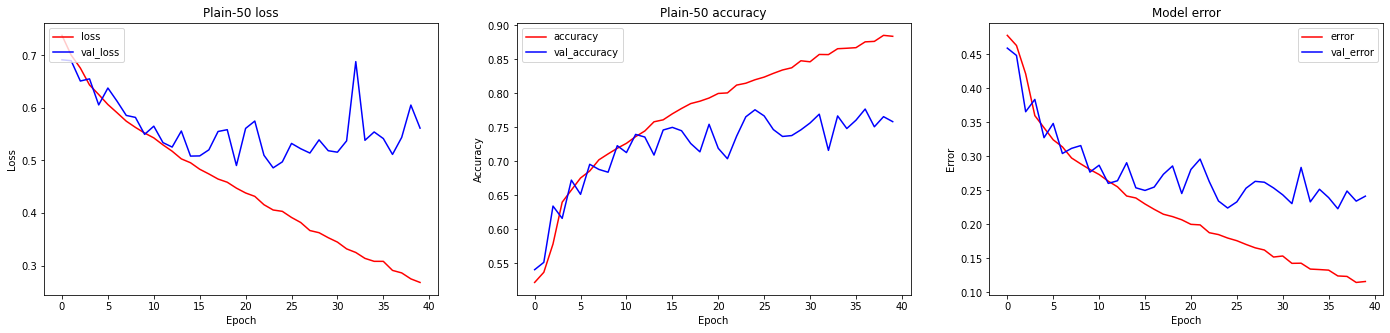

In [28]:
draw_history(hist_plain_50, 'Plain-50')

### ResNet-34 학습

In [29]:
hist_resnet_34 = train(resnet_34, 'resnet34')

Train for 581.9375 steps, validate for 145.0 steps
Epoch 1/40
582/581 [==============================] - 108s 185ms/step - loss: 0.7487 - accuracy: 0.6125 - val_loss: 0.6421 - val_accuracy: 0.6349
Epoch 2/40
582/581 [==============================] - 103s 177ms/step - loss: 0.5765 - accuracy: 0.7032 - val_loss: 0.6351 - val_accuracy: 0.6530
Epoch 3/40
582/581 [==============================] - 102s 176ms/step - loss: 0.5025 - accuracy: 0.7569 - val_loss: 0.7681 - val_accuracy: 0.6666
Epoch 4/40
582/581 [==============================] - 104s 178ms/step - loss: 0.4186 - accuracy: 0.8074 - val_loss: 0.5144 - val_accuracy: 0.7541
Epoch 5/40
582/581 [==============================] - 104s 178ms/step - loss: 0.3432 - accuracy: 0.8486 - val_loss: 0.4680 - val_accuracy: 0.7720
Epoch 6/40
582/581 [==============================] - 102s 176ms/step - loss: 0.2752 - accuracy: 0.8834 - val_loss: 0.5299 - val_accuracy: 0.7459
Epoch 7/40
582/581 [==============================] - 105s 180ms/step - l

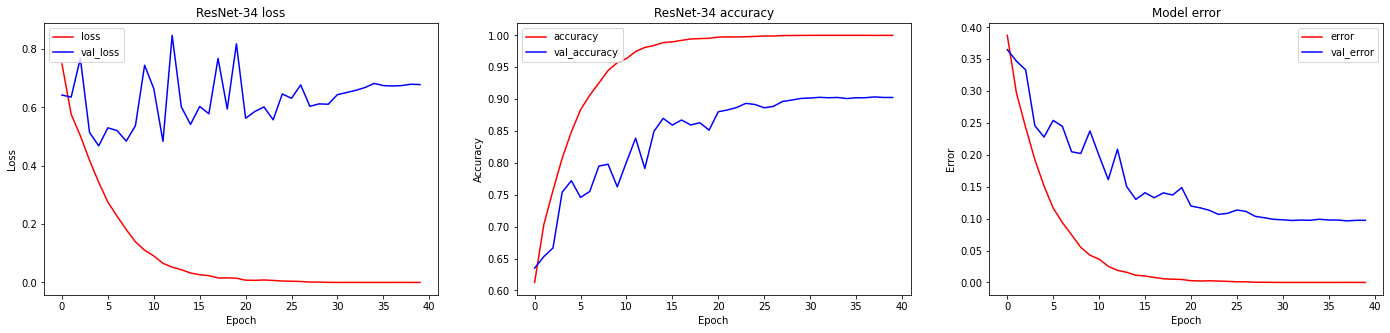

In [30]:
draw_history(hist_resnet_34, 'ResNet-34')

### ResNet-50 학습

In [31]:
hist_resnet_50 = train(resnet_50, 'resnet50')

Train for 581.9375 steps, validate for 145.0 steps
Epoch 1/40
582/581 [==============================] - 187s 321ms/step - loss: 0.8711 - accuracy: 0.5751 - val_loss: 0.6749 - val_accuracy: 0.5879
Epoch 2/40
582/581 [==============================] - 181s 311ms/step - loss: 0.6453 - accuracy: 0.6514 - val_loss: 0.5949 - val_accuracy: 0.6802
Epoch 3/40
582/581 [==============================] - 178s 305ms/step - loss: 0.5878 - accuracy: 0.6966 - val_loss: 0.5510 - val_accuracy: 0.7153
Epoch 4/40
582/581 [==============================] - 178s 306ms/step - loss: 0.5334 - accuracy: 0.7345 - val_loss: 0.7193 - val_accuracy: 0.6470
Epoch 5/40
582/581 [==============================] - 177s 305ms/step - loss: 0.4767 - accuracy: 0.7737 - val_loss: 0.6342 - val_accuracy: 0.7004
Epoch 6/40
582/581 [==============================] - 177s 304ms/step - loss: 0.4308 - accuracy: 0.8028 - val_loss: 0.4835 - val_accuracy: 0.7812
Epoch 7/40
582/581 [==============================] - 176s 302ms/step - l

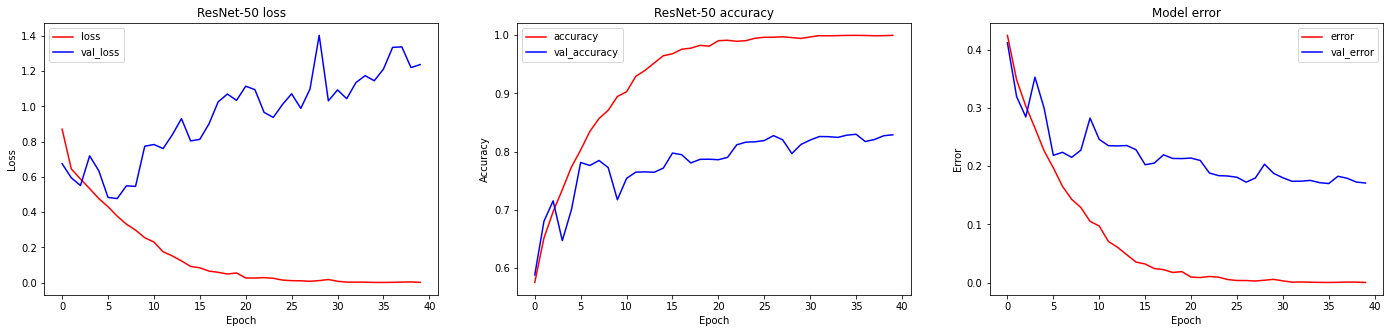

In [32]:
draw_history(hist_resnet_50, 'ResNet-50')

### 시각화

학습 결과들을 모델별로 비교하면서 그래프로 그려보자.  
다음은 두 개의 학습결과를 받아 loss, acc, error를 그려주는 함수이다.

In [48]:
def draw_ablation_study(historys, model_names):
    plt.figure(figsize=(16,16))
    plt.subplot(3, 2, 1)
    plt.plot(historys[0].history['loss'], 'r')
    plt.plot(historys[1].history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper right')

    plt.subplot(3, 2, 2)
    plt.plot(historys[0].history['val_loss'], 'r')
    plt.plot(historys[1].history['val_loss'], 'b')
    plt.title('Model validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper right')
    
    plt.subplot(3, 2, 3)
    plt.plot(historys[0].history['accuracy'], 'r')
    plt.plot(historys[1].history['accuracy'], 'b')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper left')

    plt.subplot(3, 2, 4)
    plt.plot(historys[0].history['val_accuracy'], 'r')
    plt.plot(historys[1].history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper left')
    
    plt.subplot(3, 2, 5)
    plt.plot([1-x for x in historys[0].history['accuracy']], 'r')
    plt.plot([1-x for x in historys[1].history['accuracy']], 'b')
    plt.title('Model error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper right')

    plt.subplot(3, 2, 6)
    plt.plot([1-x for x in historys[0].history['val_accuracy']], 'r')
    plt.plot([1-x for x in historys[1].history['val_accuracy']], 'b')
    plt.title('Model validation Error')
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend([model_names[0], model_names[1]], loc='upper right')
    plt.show()

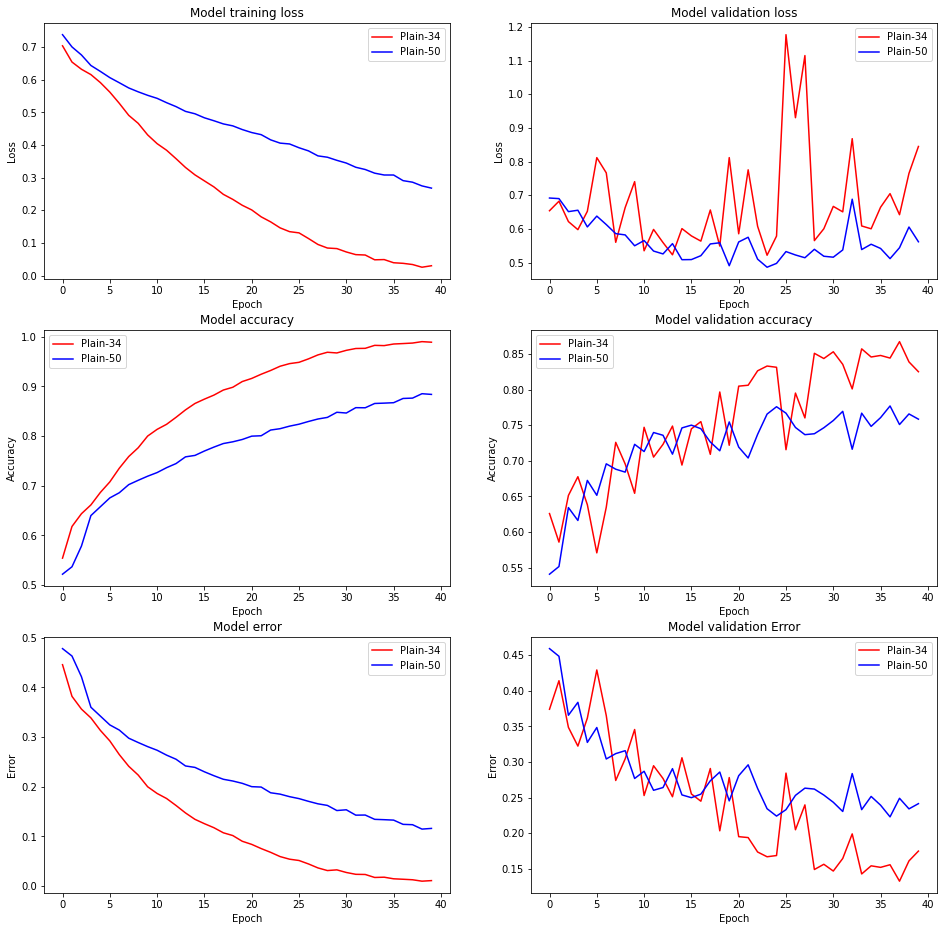

In [49]:
draw_ablation_study([hist_plain_34, hist_plain_50], ['Plain-34', 'Plain-50'])

레이어를 34에서 50으로 늘린 일반 모델은 acc및 val_acc 모두 떨어졌다.

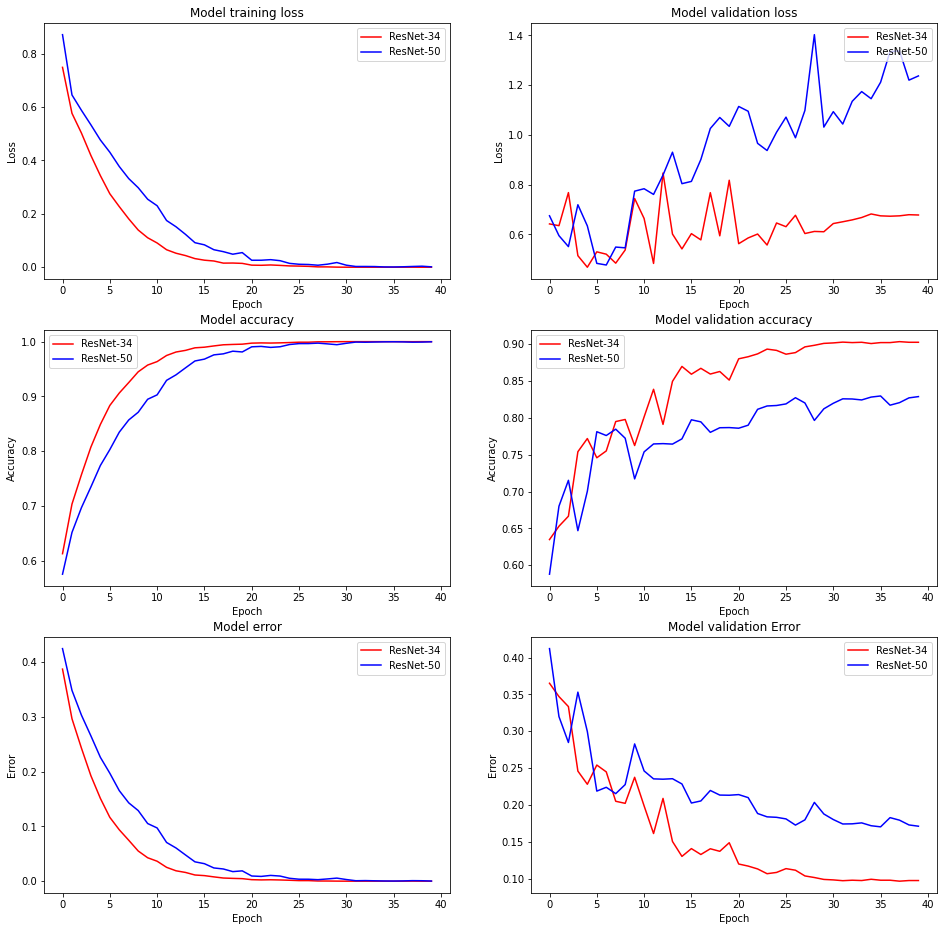

In [50]:
draw_ablation_study([hist_resnet_34, hist_resnet_50], ['ResNet-34', 'ResNet-50'])

여기가 정말 의외인 부분인데, resnet의 residual connection으로 인해 레이어가 더 깊어지면  
성능이 비슷하거나 더 좋아질거라고 예상했지만(논문에서 사용한 데이터셋에서는 그런 결과가 나왔다.),  
오히려 성능이 떨어졌다.

plain 모델과 비슷한 결과를 보여주는데, 일단 데이터셋이 train데이터에 대해 100%의 정답률이 나오기도 하고,  
개와 고양이를 나누는 단순하고 작은 데이터인것도 논문과 많이 다르긴하다.  
이 부분에 대한 원인은 좀 더 고민해 봐야할것 같다.


다음으로 같은 크기의 plain모델과 resnet모델을 비교해서 Ablation Study 효과를 확인해보았다.

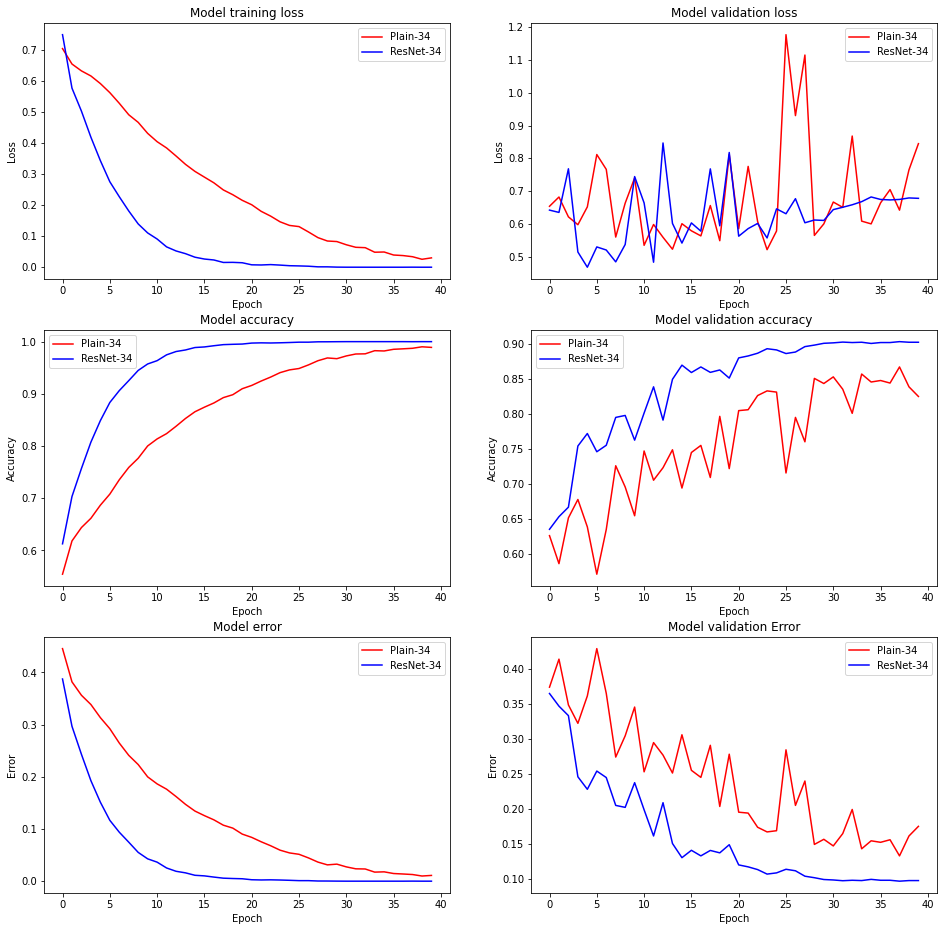

In [51]:
draw_ablation_study([hist_plain_34, hist_resnet_34], ['Plain-34', 'ResNet-34'])

확실하게 residual connection을 추가한 resnet이 test데이터에 대해 더 좋은 성능을 낸다.  
plain모델을 80번까지 돌려본 결과로도 이미 85%의 정확도로 수렴하는 모습이기에 확실하게 차이를 보인다.

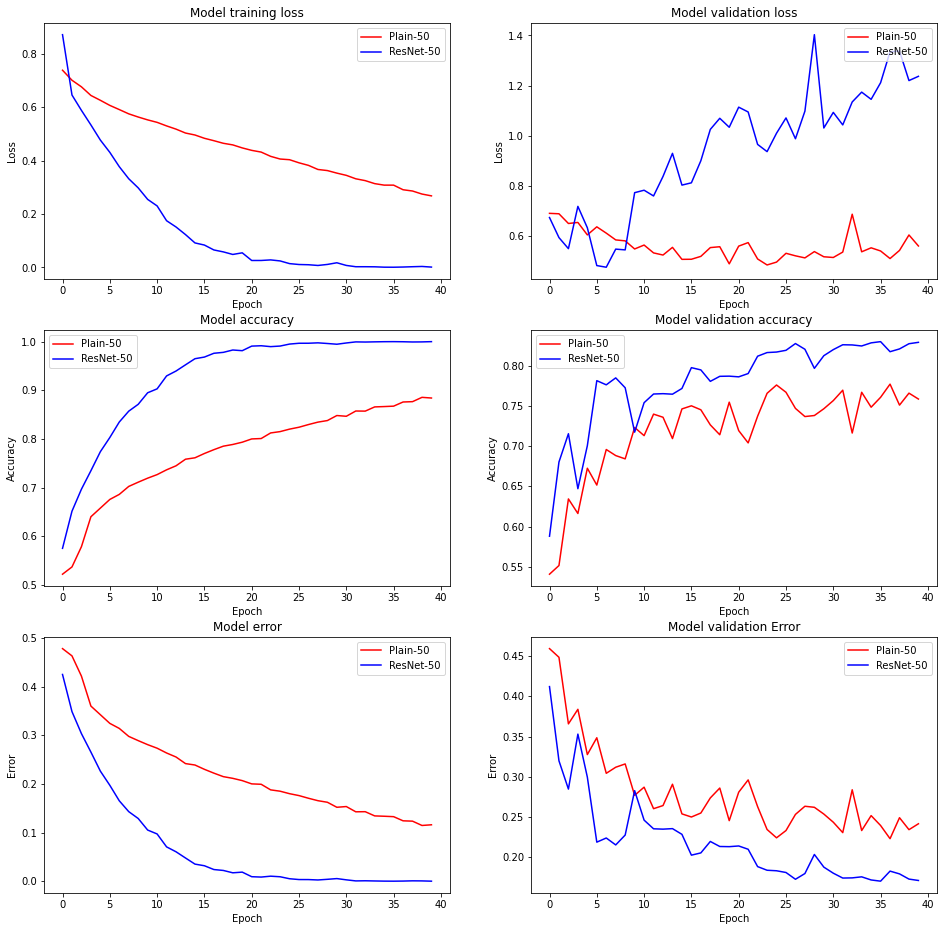

In [52]:
draw_ablation_study([hist_plain_50, hist_resnet_50], ['Plain-50', 'ResNet-50'])

plain50과 resnet50도 마찬가지이다.  

이로서 residual connection이 모델의 학습에 도움이 된다는 것은 알 수 있지만,  
논문에서 제시하는 핵심인 깊은 레이어의 모델이 더 좋은 성능을 내는지는 잘 모르겠다.  